# 230627_local_weights_v5
MLP, ATTN만 고려하는 module 단위 

# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir
import json
import math
import seaborn as sns

/rds/general/user/jj1122/home/anaconda3/envs/m2d2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
sns.set_style("darkgrid")

In [3]:
# dataset_nm = "Health_and_fitness"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"
data_dir = "../m2d2/dataset"

In [4]:
def get_model_path(model_id):
    model_path_format = "/rds/general/user/jj1122/home/projects/m2d2/dataset/{model_id}/models"
    ckpt_path_format = "/checkpoint-{ckpt}"

    if model_id == "gpt2":
        model_path = "gpt2"
#         ckpt = "zs"
    else:
        model_path = model_path_format.format(model_id=model_id)
        l_dir = listdir(model_path)

        if all([len(x.split(".")) == 1 for x in l_dir]):
            ckpt = max([int(x.split("-")[1]) for x in l_dir])
            model_path += ckpt_path_format.format(ckpt=ckpt)
#         else:
#             ckpt = "final"
    return model_path

In [5]:
list_models = [
    "cs_l1",
    "nlin_l1",
    "Health_and_fitness",
    "Natural_and_physical_sciences",
    "Religion_and_belief_systems",
    "Culture_and_the_arts",
    "General_referece",
    "econ_l1",
    "History_and_events",
    "Human_activites",
    "Mathematics_and_logic",
    "astro-ph_l1",
    "cond-mat_l1",
#     "eess_l1 (No Metric)",
    "math_l1",
#     "physics_l1 (ERROR)",
    "q-bio_l1",
#     "q-fin_l1 (No Metric)",
    "stat_l1",
    "Philosophy",
    "Philosophy_and_thinking",
    "Society_and_social_sciences",
    "Technology_and_applied_sciences",
#     "art_l1 (No Data)"
]
len(list_models), len(set(list_models))

(20, 20)

In [6]:
device_id = 'cpu'
n_layers = 12
list_modules = ['ln_1', 'attn', 'ln_2', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

## config_models

In [7]:
config_models = {model_id: {} for model_id in list_models}
for model_id in list_models:
    config_models[model_id]["model_path"] = get_model_path(model_id)
    json_path = config_models[model_id]["model_path"] + "/trainer_state.json"
    with open(json_path, "r") as json_file:
        trainer_state = json.load(json_file)
        config_models[model_id]["val_ppl"] = math.exp(trainer_state["best_metric"])
        config_models[model_id]["train_steps"] = int(trainer_state["best_model_checkpoint"].split("/")[-1].split("-")[-1])
        config_models[model_id]["train_eps"] = float(trainer_state["epoch"])

In [8]:
config_models['cs_l1']

{'model_path': '/rds/general/user/jj1122/home/projects/m2d2/dataset/cs_l1/models',
 'val_ppl': 9.60544432812854,
 'train_steps': 120000,
 'train_eps': 3.0348201502479255}

## list_module_ids

In [9]:
list_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_module_ids.append(trace_module_id.format(l=l, m=m))
list_module_ids = ["transformer.wte", "transformer.wpe"] + list_module_ids + ["transformer.ln_f"]
print(list_module_ids[:3])

with open('./data/list_module_ids_230627.json', 'w') as json_file:
    json.dump(list_module_ids, json_file) 

['transformer.wte', 'transformer.wpe', 'transformer.h.0.ln_1']


## dict_n_module_params

In [11]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)

dict_n_module_params = {}

for base_tup in list(base_model.named_parameters()):
    dict_n_module_params[base_tup[0]]= base_tup[1].numel()

with open('./data/dict_n_module_params_230627.json', 'w') as json_file:
    json.dump(dict_n_module_params, json_file) 

def parse_code_module(row):
    list_code = row.code.split(".")
    is_in_layer = row["code"].startswith("transformer.h")
    if is_in_layer:        
        row["l"] = int(list_code[2])
        row["m"] = list_code[3]
    else:
        row["m"] = list_code[1]
        if row["m"] == "ln_f": 
            row["l"] = int(99)
        elif row["m"] in ["wte", "wpe"]: 
            row['l'] = int(-1)
    row["w_or_b"] = list_code[-1]
    row["is_in_layer"] = is_in_layer
    if row["m"] in ["attn", "mlp"]:
        row["s"] = list_code[-2]
    else:
        row["s"] = row["m"]
    
    return row

df_n_module_params = pd.DataFrame.from_dict(dict_n_module_params, orient='index').reset_index()
df_n_module_params.columns = ['code', 'n_params']
df_n_module_params = df_n_module_params.apply(lambda row: parse_code_module(row), axis=1)

is_localised = (df_n_module_params.m.isin(["attn", "mlp"])) & (df_n_module_params["is_in_layer"])
df_n_module_params["is_localised"] = is_localised

df_n_module_params

,code,is_in_layer,l,m,n_params,s,w_or_b,is_localised
0,transformer.wte.weight,False,-1,wte,38597376,wte,weight,False
1,transformer.wpe.weight,False,-1,wpe,786432,wpe,weight,False
2,transformer.h.0.ln_1.weight,True,0,ln_1,768,ln_1,weight,False
3,transformer.h.0.ln_1.bias,True,0,ln_1,768,ln_1,bias,False
4,transformer.h.0.attn.c_attn.weight,True,0,attn,1769472,c_attn,weight,True
...,...,...,...,...,...,...,...,...
143,transformer.h.11.mlp.c_fc.bias,True,11,mlp,3072,c_fc,bias,True
144,transformer.h.11.mlp.c_proj.weight,True,11,mlp,2359296,c_proj,weight,True
145,transformer.h.11.mlp.c_proj.bias,True,11,mlp,768,c_proj,bias,True
146,transformer.ln_f.weight,False,99,ln_f,768,ln_f,weight,False


In [12]:
df_n_module_params_agg = df_n_module_params\
    .loc[:, ["m", "s", "n_params", "w_or_b", "is_localised"]]\
    .drop_duplicates()\
    .groupby(["is_localised", "m", "w_or_b"])[["n_params"]].sum().unstack(-1)\
    .fillna(0).astype(int)

df_n_module_params_agg
# .loc[df_n_module_params.w_or_b == "weight", ["m", "n_params", "is_in_layer"]]\

n_params          
w_or_b                bias    weight
is_localised m                      
False        ln_1      768       768
             ln_2      768       768
             ln_f      768       768
             wpe         0    786432
             wte         0  38597376
True         attn     3072   2359296
             mlp      3840   4718592

## list_submodule_ids

In [13]:
list_submodule_ids = [x[0] for x in base_model.named_parameters()]
with open('./data/list_submodule_ids_230627.json', 'w') as json_file:
    json.dump(list_submodule_ids, json_file) 


# Model

In [14]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir=cache_dir)

## load **20** finetuned models

### Get difference in weights
```diff = np.mean(np.abs(model_a.weights - model_b.weights))```

### Scaling the difference of weights
For each dataset, ```new_diff = original_diff  / n_steps  * 10**6```

### submodule

In [15]:
def get_diff_from_tensors_sub(a, b):
    return torch.abs(a - b).mean().item()

dict_diff_weights = {}
for k, v_dict in config_models.items():
    tuned_model = GPT2LMHeadModel.from_pretrained(v_dict["model_path"]).to(device_id)
    for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
        dict_diff_weights[k +"."+tuned_tup[0]] = get_diff_from_tensors_sub(tuned_tup[1], base_tup[1]) 
    del tuned_model

In [16]:
df_avg_diff_weights = pd.DataFrame.from_dict(dict_diff_weights, orient='index')

df_avg_diff_weights = df_avg_diff_weights.reset_index()
df_avg_diff_weights.columns = ["code", "diff"]

df_avg_diff_weights["code_split"] = df_avg_diff_weights["code"].str.split(".")
df_avg_diff_weights["dataset"] = df_avg_diff_weights["code_split"].apply(lambda l: l[0])

df_avg_diff_weights["layer"] = df_avg_diff_weights["code_split"].apply(lambda l: int(l[3]) if l[2] == "h" else -1)


df_avg_diff_weights["module"] = df_avg_diff_weights["code_split"].apply(lambda l: l[4] if l[2] == "h" else l[2])
df_avg_diff_weights["sub_module"] = df_avg_diff_weights["module"]
df_avg_diff_weights.loc[df_avg_diff_weights["module"].isin(["attn", "mlp"]), "sub_module"] \
    += df_avg_diff_weights["code_split"].loc[df_avg_diff_weights["module"].isin(["attn", "mlp"])].apply(lambda l: l[5])

df_avg_diff_weights.loc[df_avg_diff_weights["sub_module"] == "ln_f", "layer"] = 99

df_avg_diff_weights["w_or_b"] = df_avg_diff_weights["code_split"].apply(lambda l: l[-1])

for dataset, d in config_models.items():
    for k, v in d.items():
        if k != "model_path":
            df_avg_diff_weights.loc[df_avg_diff_weights.dataset == dataset, k] = v

only_transformer_layers = ~(df_avg_diff_weights.layer.isin([-1, 99]))

df_avg_diff_weights['scaled_diff'] = df_avg_diff_weights['diff'] / df_avg_diff_weights['train_steps'] * 10**6
df_avg_diff_weights['component_id'] = df_avg_diff_weights['code'].apply(lambda x: ".".join(x.split(".")[2:-1]))

df_avg_diff_weights_sub = df_avg_diff_weights[:]
df_avg_diff_weights_sub.to_pickle("data/df_avg_diff_weights_sub_230627.pkl")

### module

In [108]:
def get_diff_from_tensors(a, b, return_mean=True):
    if return_mean:
        return torch.abs(a - b).mean().item()
    else:
        return torch.abs(a - b)

dict_diff_weights = {}
for k, v_dict in config_models.items():
    tuned_model = GPT2LMHeadModel.from_pretrained(v_dict["model_path"]).to(device_id)
    for module_id in list_module_ids:
        list_submodule_diff = []
        for tuned_tup, base_tup in zip(base_model.get_submodule(module_id).named_parameters(), tuned_model.get_submodule(module_id).named_parameters()):
            assert tuned_tup[0] == base_tup[0]
            if "bias" in tuned_tup[0]: continue # TODO
            list_submodule_diff.append(get_diff_from_tensors(tuned_tup[1], base_tup[1], False).flatten())
        dict_diff_weights[k +"."+module_id] = torch.concat(list_submodule_diff).mean().item()

In [109]:
df_avg_diff_weights = pd.DataFrame.from_dict(dict_diff_weights, orient='index')

df_avg_diff_weights = df_avg_diff_weights.reset_index()
df_avg_diff_weights.columns = ["code", "diff"]

df_avg_diff_weights.head()

df_avg_diff_weights["code_split"] = df_avg_diff_weights["code"].str.split(".")
df_avg_diff_weights["dataset"] = df_avg_diff_weights["code_split"].apply(lambda l: l[0])
df_avg_diff_weights["layer"] = df_avg_diff_weights["code_split"].apply(lambda l: int(l[3]) if l[2] == "h" else -1)
df_avg_diff_weights["module"] = df_avg_diff_weights["code_split"].apply(lambda l: l[4] if l[2] == "h" else l[2])
df_avg_diff_weights.loc[df_avg_diff_weights["module"] == "ln_f", "layer"] = 99

for dataset, d in config_models.items():
    for k, v in d.items():
        if k != "model_path":
            df_avg_diff_weights.loc[df_avg_diff_weights.dataset == dataset, k] = v

is_in_layer = ~(df_avg_diff_weights.layer.isin([-1, 99]))
df_avg_diff_weights["is_in_layer"] = is_in_layer

is_localised = (df_avg_diff_weights.module.isin(["attn", "mlp"])) & is_in_layer
df_avg_diff_weights["is_localised"] =  is_localised


df_avg_diff_weights['scaled_diff'] = df_avg_diff_weights['diff'] / df_avg_diff_weights['train_steps'] * 10**6
df_avg_diff_weights['component_id'] = df_avg_diff_weights['code'].apply(lambda x: ".".join(x.split(".")[2:-1])) + "." + df_avg_diff_weights['module']
df_avg_diff_weights.loc[~(df_avg_diff_weights.is_in_layer), "component_id"] = df_avg_diff_weights['module']
df_avg_diff_weights.to_pickle("data/df_avg_diff_weights_mod_230627.pkl")

In [111]:
df_avg_diff_weights.component_id.unique()

array(['wte', 'wpe', 'h.0.ln_1', 'h.0.attn', 'h.0.ln_2', 'h.0.mlp',
       'h.1.ln_1', 'h.1.attn', 'h.1.ln_2', 'h.1.mlp', 'h.2.ln_1',
       'h.2.attn', 'h.2.ln_2', 'h.2.mlp', 'h.3.ln_1', 'h.3.attn',
       'h.3.ln_2', 'h.3.mlp', 'h.4.ln_1', 'h.4.attn', 'h.4.ln_2',
       'h.4.mlp', 'h.5.ln_1', 'h.5.attn', 'h.5.ln_2', 'h.5.mlp',
       'h.6.ln_1', 'h.6.attn', 'h.6.ln_2', 'h.6.mlp', 'h.7.ln_1',
       'h.7.attn', 'h.7.ln_2', 'h.7.mlp', 'h.8.ln_1', 'h.8.attn',
       'h.8.ln_2', 'h.8.mlp', 'h.9.ln_1', 'h.9.attn', 'h.9.ln_2',
       'h.9.mlp', 'h.10.ln_1', 'h.10.attn', 'h.10.ln_2', 'h.10.mlp',
       'h.11.ln_1', 'h.11.attn', 'h.11.ln_2', 'h.11.mlp', 'ln_f'],
      dtype=object)

# Analyse Modules

## Diff vs. Scaled_Diff

In [112]:
df_avg_diff_weights\
    .groupby(["is_in_layer", "is_localised", "layer",  "component_id"])\
    .agg({"diff": ["mean", "std", pd.DataFrame.kurtosis], "scaled_diff": ["mean", "std", pd.DataFrame.kurtosis]})

diff                       
                                                 mean       std      kurt   
is_in_layer is_localised layer component_id                                 
False       False        -1    wpe           0.013534  0.004271 -0.559784  \
                               wte           0.033362  0.017121 -0.436712   
                          99   ln_f          0.059934  0.053168  5.269219   
True        False         0    h.0.ln_1      0.062964  0.037279  0.811735   
                               h.0.ln_2      0.038000  0.021498  1.510665   
                          1    h.1.ln_1      0.027600  0.026116  1.966494   
                               h.1.ln_2      0.019892  0.021885  2.948193   
                          2    h.2.ln_1      0.034759  0.031796  1.978863   
                               h.2.ln_2      0.024571  0.027235  2.969629   
                          3    h.3.ln_1      0.040355  0.039124  1.756517   
                               h.3.ln_2      0.029065  0.030565  2.860716   
                          4    h.4.ln_1      0.039004  0.037614  1.750409   
                               h.4.ln_2      0.028706  0.028106  2.885266   
                          5    h.5.ln_1      0.045856  0.045798  1.763440   
                               h.5.ln_2      0.034727  0.031959  2.463349   
                          6    h.6.ln_1      0.043918  0.041994  1.704301   
                               h.6.ln_2      0.032999  0.030265  2.471975   
                          7    h.7.ln_1      0.049617  0.049667  1.532280   
                               h.7.ln_2      0.031654  0.029884  2.664916   
                          8    h.8.ln_1      0.049749  0.048972  1.576404   
                               h.8.ln_2      0.028916  0.028845  3.001150   
                          9    h.9.ln_1      0.048200  0.049202  1.706330   
                               h.9.ln_2      0.024534  0.026847  3.649818   
                          10   h.10.ln_1     0.047070  0.048475  1.788138   
                               h.10.ln_2     0.016556  0.019104  6.009687   
                          11   h.11.ln_1     0.031343  0.031302  3.075317   
                               h.11.ln_2     0.071525  0.033695 -1.292521   
            True          0    h.0.attn      0.032951  0.017203 -0.436744   
                               h.0.mlp       0.023995  0.012498 -0.433519   
                          1    h.1.attn      0.025428  0.013475 -0.438109   
                               h.1.mlp       0.023108  0.011966 -0.446834   
                          2    h.2.attn      0.027705  0.014408 -0.458304   
                               h.2.mlp       0.025021  0.012811 -0.467403   
                          3    h.3.attn      0.027651  0.014249 -0.482691   
                               h.3.mlp       0.025321  0.012825 -0.495711   
                          4    h.4.attn      0.028517  0.014714 -0.484787   
                               h.4.mlp       0.025331  0.012775 -0.500875   
                          5    h.5.attn      0.026842  0.013512 -0.513381   
                               h.5.mlp       0.026094  0.013128 -0.514077   
                          6    h.6.attn      0.028021  0.014224 -0.511978   
                               h.6.mlp       0.027363  0.013820 -0.514889   
                          7    h.7.attn      0.028835  0.014580 -0.540058   
                               h.7.mlp       0.029028  0.014704 -0.512709   
                          8    h.8.attn      0.029310  0.014954 -0.524865   
                               h.8.mlp       0.030982  0.015770 -0.494589   
                          9    h.9.attn      0.029971  0.015291 -0.493967   
                               h.9.mlp       0.033457  0.017104 -0.470857   
                          10   h.10.attn     0.030425  0.015353 -0.501128   
                               h.10.mlp      0.036052  0.018488 -0.445756   
                          11   h.11.attn     

## Params for Editing or Compression

In [126]:
df_n_module_params_agg_v2 = df_n_module_params_agg.reset_index().drop("is_localised", axis=1)
df_n_module_params_agg_v2.columns = ["module", "bias", "weight"]
df_n_module_params_agg_v2["total"] = df_n_module_params_agg_v2["bias"] + df_n_module_params_agg_v2["weight"] 

/var/tmp/pbs.7839234.pbs/ipykernel_2033711/1670945437.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_n_module_params_agg_v2 = df_n_module_params_agg.reset_index().drop("is_localised", axis=1)


In [131]:
df_modules = df_avg_diff_weights\
    .groupby(["is_in_layer", "is_localised", "layer",  "component_id", "module"])[["diff", "scaled_diff"]].mean().reset_index()\
    .merge(df_n_module_params_agg_v2, on=["module"], how='left')

df_modules.loc[df_modules.is_localised, "rank"]\
    = df_modules.loc[df_modules.is_localised]["scaled_diff"].rank(ascending=False)
df_modules["rank"] = df_modules["rank"].fillna(-1).astype(int)

In [128]:
df_modules.total.sum()

124439808

In [129]:
n_total_params = sum(p.numel() for p in base_model.parameters())
n_total_params

124439808

In [135]:
n_localised_mods = len(df_modules.loc[df_modules["is_localised"]])
df_modules['threshold'] = 100
for threshold in np.arange(0.8, -0.01, -0.2):
    df_modules.loc[df_modules["rank"] < threshold*n_localised_mods, 'threshold'] = int(threshold * 100)

df_modules_agg = df_modules.groupby(["threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_modules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_modules_agg["accum_params"] = df_modules_agg["params"].cumsum()
df_modules_agg["accum_prop_params"] = df_modules_agg["accum_params"] / n_total_params
df_modules_agg["component_ids"] = df_modules_agg["component_ids"].apply(lambda l: ", ".join(l))


In [136]:
df_modules_agg

,component_ids,mod_cnt,params,accum_params,accum_prop_params
threshold,,,,,
0,"wpe, wte, ln_f, h.0.ln_1, h.0.ln_2, h.1.ln_1, ...",27,39422208,39422208,0.316797
20,"h.0.attn, h.9.mlp, h.10.mlp, h.11.mlp",4,16529664,55951872,0.449630
40,"h.8.attn, h.8.mlp, h.9.attn, h.10.attn, h.11.attn",5,14171904,70123776,0.563516
60,"h.4.attn, h.6.attn, h.6.mlp, h.7.attn, h.7.mlp",5,16531968,86655744,0.696367
80,"h.2.attn, h.3.attn, h.4.mlp, h.5.attn, h.5.mlp",5,16531968,103187712,0.829218
100,"h.0.mlp, h.1.attn, h.1.mlp, h.2.mlp, h.3.mlp",5,21252096,124439808,1.000000


## IN vs. ALL Rank Comparision

In [137]:
df_avg_diff_weights.loc[df_avg_diff_weights.is_localised, "in_rank"] \
    = df_avg_diff_weights.loc[df_avg_diff_weights.is_localised].groupby(["dataset"])["diff"].rank(ascending=False)
# df_avg_diff_weights.loc[df_avg_diff_weights.is_localised, "in_scaled_rank"] \
#     = df_avg_diff_weights.loc[df_avg_diff_weights.is_localised].groupby(["dataset"])["scaled_diff"].rank(ascending=False)

df_avg_diff_weights["in_rank"] = df_avg_diff_weights["in_rank"].fillna(-1).astype(int)
# df_avg_diff_weights["in_scaled_rank"] = df_avg_diff_weights["in_scaled_rank"].fillna(-1).astype(int)


df_in_rank = df_avg_diff_weights.loc[df_avg_diff_weights.is_localised].groupby(["layer", "component_id"])["in_rank"].describe()[["mean", "std"]]
df_in_rank = df_in_rank.rename({"mean":"in_rank_mean", "std":"in_rank_std"}, axis=1)

df_modules.loc[df_modules.is_localised, ["layer", "component_id", "threshold", "rank"]].sort_values('rank')\
    .rename({"rank": "all_rank"}, axis=1)\
    .merge(df_in_rank.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

# Visualisation

### boxplot for the scaled and mean weight- and bias-differences by layers


<Axes: xlabel='layer', ylabel='scaled_diff'>

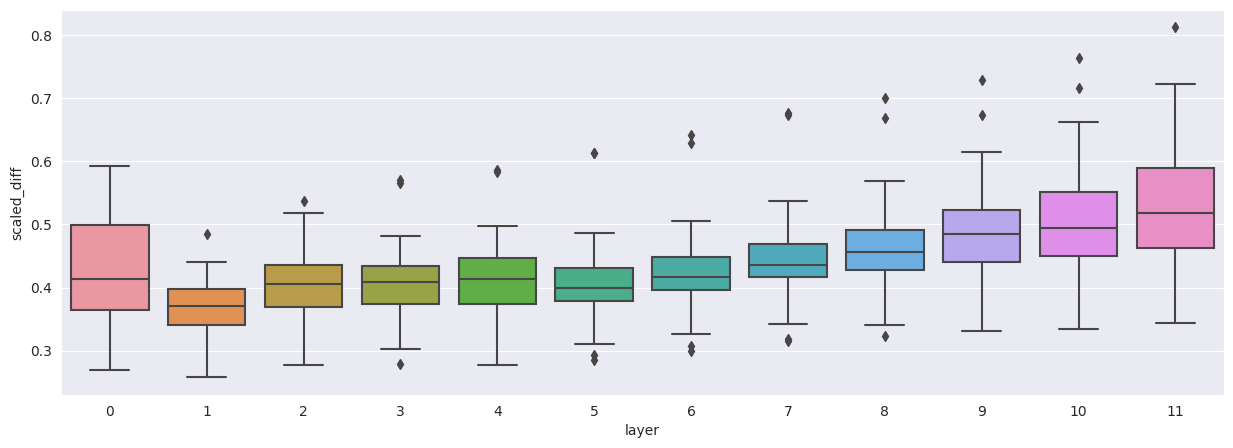

In [91]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_localised],
    x='layer',  y='scaled_diff'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)

<Axes: xlabel='layer', ylabel='scaled_diff'>

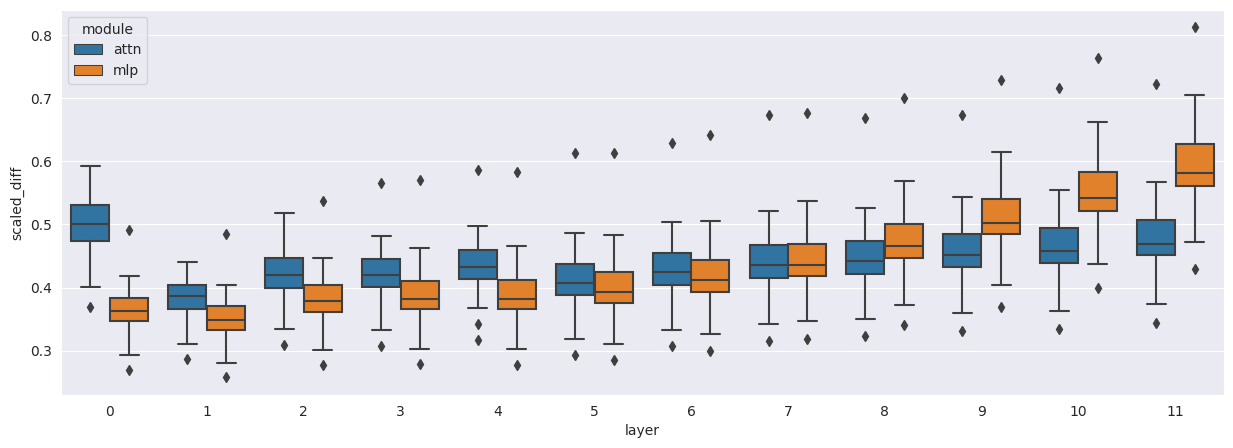

In [46]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_localised],
    x='layer',  y='scaled_diff', hue='module'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)